# Logistic Regression

- similar to linear regression in that logistic regression predicts a target based on weights assigned to each feature
- sigmoid function is used to constrain the predicted probability to between 0 and 1
- sigmoid function $f(x) = \frac{1}{1+e^{-x}}$
- as x approaches infinity, f(x) gets closer to 1
- as x approaches negative infinity, f(x) gets closer to 0

Why use logistic regression for classification problems?
- features can be dichotomous, categorical or numerical
- features does not need to be normally distributed
- the target variable can have more than two possible values, and can be nominal or ordinal
- relationship between features and the target is not assumed to be linear

## Binary Classification with Logistic Regression

### Goal

We will build a model to predict if an individual will have heart disease based on personal characteristics such as smoking and alcohol drinking habits; health features, including BMP, asthma, diabetes, and skin cancer; and age.

### Importing dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skmet
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data.load import load_healthinfosample

# Custom dependencies
from preprocfunc import MakeOrdinal, OutlierTrans, ReplaceVals

### Load data

In [2]:
healthinfo = load_healthinfosample()
healthinfo.head(2).T

personid,299391,252786
heartdisease,Yes,No
bmi,28.48,25.24
smoking,Yes,Yes
alcoholdrinkingheavy,No,No
stroke,No,No
physicalhealthbaddays,7,0
mentalhealthbaddays,0,2
walkingdifficult,No,No
gender,Male,Female
agecategory,70-74,65-69


^ The `agecategory` feature is a character data that represents the age interval. We will need to convert that feature into numeric.

```
agecategory	70-74	65-69
```

### Check for missing values

In [3]:
healthinfo.shape

(30000, 18)

In [4]:
healthinfo.isnull().sum()

heartdisease             0
bmi                      0
smoking                  0
alcoholdrinkingheavy     0
stroke                   0
physicalhealthbaddays    0
mentalhealthbaddays      0
walkingdifficult         0
gender                   0
agecategory              0
ethnicity                0
diabetic                 0
physicalactivity         0
genhealth                0
sleeptimenightly         0
asthma                   0
kidneydisease            0
skincancer               0
dtype: int64

^ We don't have any missing values. 

### Target column

The target column is `heartdisease`. We need to transform it into a `0` and `1` variable.

In [5]:
healthinfo.heartdisease.value_counts()

No     27467
Yes     2533
Name: heartdisease, dtype: int64

In [6]:
healthinfo.heartdisease.value_counts(normalize=True)

No     0.915567
Yes    0.084433
Name: heartdisease, dtype: float64

^ Less than 10% of our observations have heartdisease. Our target's values are quite imbalanced.

In [7]:
healthinfo["heartdisease"] = np.where(healthinfo.heartdisease == "No", 0, 1).astype(int)

In [8]:
healthinfo.heartdisease.value_counts()

0    27467
1     2533
Name: heartdisease, dtype: int64

### Preprocessing

- scaling `numeric` features
- one-hot encoding `categorical` features
- convert to `ordinal` features

In [9]:
num_cols = ["bmi", "physicalhealthbaddays", "mentalhealthbaddays", "sleeptimenightly"]
binary_cols = [
    "smoking",
    "alcoholdrinkingheavy",
    "stroke",
    "walkingdifficult",
    "physicalactivity",
    "asthma",
    "kidneydisease",
    "skincancer",
]

cat_cols = ["gender", "ethnicity"]
spec_cols1 = ["agecategory"]
spec_cols2 = ["genhealth"]
spec_cols3 = ["diabetic"]

In [10]:
rep_dict = {
    "genhealth": {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4},
    "diabetic": {
        "No": 0,
        "No, borderline diabetes": 0,
        "Yes": 1,
        "Yes (during pregnancy)": 1,
    },
}

### EDA
- explore binary features
- explore categorical features
- explore numeric features

In [11]:
healthinfo[binary_cols].apply(pd.value_counts, normalize=True).T

,No,Yes
smoking,0.584300,0.415700
alcoholdrinkingheavy,0.933133,0.066867
stroke,0.962200,0.037800
walkingdifficult,0.862467,0.137533
physicalactivity,0.227267,0.772733
asthma,0.865500,0.134500
kidneydisease,0.962500,0.037500
skincancer,0.906233,0.093767


^ how to interpret? A large percentage of the individuals (42%) report that they have been smokers. 14% report that they have difficulty walking.

Template:

```
n% report that <cause>
```

In [12]:
for col in cat_cols + ["genhealth", "diabetic"]:
    print(
        col,
        "------------------------------",
        healthinfo[col].value_counts(normalize=True).sort_index(),
        sep="\n",
        end="\n\n",
    )

gender
------------------------------
Female    0.5229
Male      0.4771
Name: gender, dtype: float64

ethnicity
------------------------------
American Indian/Alaskan Native    0.017000
Asian                             0.026333
Black                             0.070667
Hispanic                          0.085733
Other                             0.033533
White                             0.766733
Name: ethnicity, dtype: float64

genhealth
------------------------------
Excellent    0.207200
Fair         0.110733
Good         0.291533
Poor         0.035400
Very good    0.355133
Name: genhealth, dtype: float64

diabetic
------------------------------
No                         0.844767
No, borderline diabetes    0.022367
Yes                        0.125100
Yes (during pregnancy)     0.007767
Name: diabetic, dtype: float64



^ There are nearly equal numbers of men and women.

Most people report excellent or very good health.

In [13]:
healthinfo[num_cols].agg(["count", "min", "median", "max"]).T

,count,min,median,max
bmi,30000.0,12.02,27.34,91.55
physicalhealthbaddays,30000.0,0.00,0.00,30.00
mentalhealthbaddays,30000.0,0.00,0.00,30.00
sleeptimenightly,30000.0,1.00,7.00,24.00


- we need to do scaling
- we need to do some encoding of the categorical features
- we need to remove extreme values for some numerical features. A `sleeptimenightly` value of 24 seems unlikely

### Create train and test data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    healthinfo[
        num_cols + binary_cols + cat_cols + spec_cols1 + spec_cols2 + spec_cols3
    ],
    healthinfo["heartdisease"],
    test_size=0.2,
    random_state=0,
)

### Column transformation

- categorical features - one-hot encoding
- numeric features - remove extreme values, impute median
- convert `agecategory` features into ordinal values using `MakeOrdinal`
- replace `genhealth` and `diabetic` features using the `ReplaceVals`

In [15]:
ohe = OneHotEncoder(drop="first", sparse=False)

standtrans = make_pipeline(
    OutlierTrans(3), SimpleImputer(strategy="median"), StandardScaler()
)
spectrans1 = make_pipeline(MakeOrdinal(), StandardScaler())
spectrans2 = make_pipeline(ReplaceVals(rep_dict), StandardScaler())
spectrans3 = make_pipeline(ReplaceVals(rep_dict))
bintrans = make_pipeline(ohe)
cattrans = make_pipeline(ohe)
coltrans = ColumnTransformer(
    transformers=[
        ("stand", standtrans, num_cols),
        ("spec1", spectrans1, spec_cols1),
        ("spec2", spectrans2, spec_cols2),
        ("spec3", spectrans3, spec_cols3),
        ("bin", bintrans, binary_cols),
        ("cat", cattrans, cat_cols),
    ]
)

### Setup pipeline

- setup a logistic regression and instantiate a stratified k-fold object
- recall that the recursive feature elimination needs an estimator
- remember that our dataset is imbalanced
- we use stratified k-fold to get approximately the same target value distribution in each fold
- we create another logistic regresion instance for our model
- set the `class_weight` to `balanced` 
- this should improve the model's ability to deal with the class imbalance

In [16]:
lrsel = LogisticRegression(random_state=1, max_iter=1000)
kf = StratifiedKFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=lrsel, cv=kf)
lr = LogisticRegression(random_state=1, class_weight="balanced", max_iter=1000)

pipe1 = make_pipeline(coltrans, rfecv, lr)
pipe1.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('stand',
                                                  Pipeline(steps=[('outliertrans',
                                                                   OutlierTrans(threshold=3)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['bmi',
                                                   'physicalhealthbaddays',
                                                   'mentalhealthbaddays',
                                                   'sleeptimenightly']),
                                                 ('spec1',
                                                  Pipeline(steps=[('makeordinal',
                                                                   MakeOrdina...
                                                   'skincancer']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['gender', 'ethnicity'])])),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                       estimator=LogisticRegression(max_iter=1000,
                                                    random_state=1))),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=1))])

We need to do a little work to recover the column names from the pipeline after the fit. 

We should only get the column names for the binary and categorical features after the encoding. The names of the numerical features remained unchanged.

In [17]:
new_binary_cols = (
    pipe1.named_steps["columntransformer"]
    .named_transformers_["bin"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
)
new_binary_cols

array(['smoking_Yes', 'alcoholdrinkingheavy_Yes', 'stroke_Yes',
       'walkingdifficult_Yes', 'physicalactivity_Yes', 'asthma_Yes',
       'kidneydisease_Yes', 'skincancer_Yes'], dtype=object)

In [18]:
new_cat_cols = (
    pipe1.named_steps["columntransformer"]
    .named_transformers_["cat"]
    .named_steps["onehotencoder"]
    .get_feature_names_out()
)
new_cat_cols

array(['gender_Male', 'ethnicity_Asian', 'ethnicity_Black',
       'ethnicity_Hispanic', 'ethnicity_Other', 'ethnicity_White'],
      dtype=object)

In [19]:
new_cols = np.concatenate(
    (
        np.array(num_cols + spec_cols1 + spec_cols2 + spec_cols3),
        new_binary_cols,
        new_cat_cols,
    )
)
new_cols

array(['bmi', 'physicalhealthbaddays', 'mentalhealthbaddays',
       'sleeptimenightly', 'agecategory', 'genhealth', 'diabetic',
       'smoking_Yes', 'alcoholdrinkingheavy_Yes', 'stroke_Yes',
       'walkingdifficult_Yes', 'physicalactivity_Yes', 'asthma_Yes',
       'kidneydisease_Yes', 'skincancer_Yes', 'gender_Male',
       'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic',
       'ethnicity_Other', 'ethnicity_White'], dtype=object)

### Recursive Feature Elimination

We can use the `ranking_` attribute of the `rfecv` object to get the ranking of each feature. Those with `1` for ranking will be selected for our model.

If we use the `get_support` method or the `support_` attribute of the `rfecv` object, we get just those features that will be used in our model.

In [20]:
rankinglabs = np.column_stack((pipe1.named_steps["rfecv"].ranking_, new_cols))
pd.DataFrame(rankinglabs, columns=["rank", "feature"]).sort_values(
    ["rank", "feature"]
).set_index("rank")

,feature
rank,
1,agecategory
1,alcoholdrinkingheavy_Yes
1,asthma_Yes
1,diabetic
1,ethnicity_Asian
1,ethnicity_Other
1,ethnicity_White
1,gender_Male
1,genhealth


In [21]:
pipe1.named_steps["rfecv"].support_

array([False, False, False, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True,  True, False,
       False,  True,  True])

In [22]:
new_cols[pipe1.named_steps["rfecv"].get_support()]

array(['agecategory', 'genhealth', 'diabetic', 'smoking_Yes',
       'alcoholdrinkingheavy_Yes', 'stroke_Yes', 'asthma_Yes',
       'kidneydisease_Yes', 'gender_Male', 'ethnicity_Asian',
       'ethnicity_Other', 'ethnicity_White'], dtype=object)

### Logistic Regression coefficients

We can get the _odds ratio_ from the coefficients from the logistic regression. Recall that the odds ratio is the exponentiated coefficient. There are 10 coefficients because we have 10 features.

In [23]:
oddsratios = np.exp(pipe1.named_steps["logisticregression"].coef_)

oddsratios.shape

(1, 12)

In [24]:
sel_cols = new_cols[pipe1.named_steps["rfecv"].get_support()]
oddswithlabs = np.column_stack((oddsratios.ravel(), sel_cols))

pd.DataFrame(oddswithlabs, columns=["odds", "feature"]).sort_values(
    ["odds"], ascending=False
).set_index("odds")

,feature
odds,
3.155548,stroke_Yes
2.917318,agecategory
2.080401,gender_Male
2.028069,kidneydisease_Yes
1.793517,diabetic
1.562906,smoking_Yes
1.542427,asthma_Yes
1.279657,ethnicity_Other
1.204887,ethnicity_White


^ If the individual had stroke, they had three times the odds of having heart disease. The odds of having heart disease increase by 2.95 times for each increase in age category.

On the other hand, the odds of having heart disease decline by half (55%) for every increase in general health. Surprisingly, heavy alcohol drinking is associated with lower odds of heart disease.

### Evaluating a logistic regression model

[Text(0.5, 1.0, 'Heart Disease Prediction Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

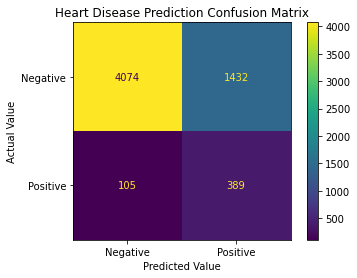

In [30]:
y_pred = pipe1.predict(X_test)
cm = skmet.confusion_matrix(y_test, y_pred)
cmplot = skmet.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Negative", "Positive"]
)
cmplot.plot()

cmplot.ax_.set(
    title="Heart Disease Prediction Confusion Matrix",
    xlabel="Predicted Value",
    ylabel="Actual Value",
)

In [31]:
print(skmet.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      5506
           1       0.21      0.79      0.34       494

    accuracy                           0.74      6000
   macro avg       0.59      0.76      0.59      6000
weighted avg       0.91      0.74      0.80      6000



^ The biggest problem with our model is the very low level of precision - that is 21%. This is due to the large number of false positives. The majority of the time that our model predicts positive, it is wrong.

From the equation $precision = \frac{tp}{tp + fp}$, an increase in _false positive_ leads to decrease in _precision_.

In [32]:
tn, fp, fn, tp = skmet.confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (tn + fp)
fpr

0.2600799128223756

^ 26% of the time that a person does not have a heart disease, we predicted that they do.

### Analyse the prediction probabilities generated by our model

The threshold for a positive class prediction is 0.5, which is often the default for logistic regression. 

In [33]:
pred_probs = pipe1.predict_proba(X_test)[:, 1]

prob_df = pd.DataFrame(
    zip(pred_probs, y_pred, y_test), columns=["prob", "pred", "actual"]
)
prob_df.groupby(["pred"])["prob"].agg(["min", "max", "count"])

,min,max,count
pred,,,
0,0.007885,0.499866,4179
1,0.500054,0.994643,1821


We can use **kernel density estimate (KDE)** plot to visualize these probabilities. We can also see how a different decision rule may impact our predictions. For example, we can move our thresholds from 0.5 to 0.25. 

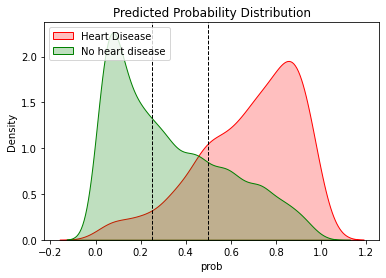

In [34]:
# Plot the labels.
sns.kdeplot(
    prob_df.loc[prob_df.actual == 1].prob,
    shade=True,
    color="red",
    label="Heart Disease",
)
sns.kdeplot(
    prob_df.loc[prob_df.actual == 0].prob,
    shade=True,
    color="green",
    label="No heart disease",
)

# Plot the threshold at 0.25 and 0.5.
plt.axvline(0.25, color="black", linestyle="dashed", linewidth=1)
plt.axvline(0.5, color="black", linestyle="dashed", linewidth=1)
plt.title("Predicted Probability Distribution")
plt.legend(loc="upper left")

^ What happens if we move the threshold from 0.5 to 0.25? At a glance, that has some advantages. The area between the two possible thresholds has somewhat more heart disease cases than no heart disease cases. 

We would be getting sthe brown area between the dashed lines right, predicting heart disease correctly where we would not have with the 0.5 threshold. That is a larger area than the green area between the lines, where we turn some of the true negative predictions at the 0.5 threshold into false positives at the 0.25 threshold.

### Metrics: Precision-Recall Curve

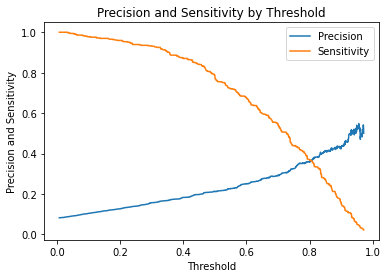

In [35]:
precision, sensitivity, thresholds = skmet.precision_recall_curve(y_test, pred_probs)
sensitivity = sensitivity[1:-20]
precision = precision[1:-20]
thresholds = thresholds[:-20]

fig, ax = plt.subplots()
ax.plot(thresholds, precision, label="Precision")
ax.plot(thresholds, sensitivity, label="Sensitivity")
ax.set_title("Precision and Sensitivity by Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Precision and Sensitivity")
ax.legend()

^ As the threshold increases beyond 0.2, there is a sharper decrease in sensitivity than there is an increase in precision.

TODO
- how to evaluate the precision/sensitivity graph?

### Metrics: ROC Curve

It is often also helpful to look at the false positive rate with the sensitivity rate. The false positive rate is the propensity of our model to predict positive when the actual value is negative. One way to see the relationship is with a ROC curve.

[Text(0.5, 1.0, 'ROC curve'),
 Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'Sensitivity')]

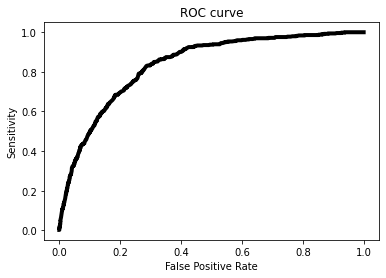

In [36]:
fpr, tpr, ths = skmet.roc_curve(y_test, pred_probs)
fpr = fpr[1:]
tpr = tpr[1:]
ths = ths[1:]

fig, ax = plt.subplots()
ax.plot(fpr, tpr, linewidth=4, color="black")
ax.set(title="ROC curve", xlabel="False Positive Rate", ylabel="Sensitivity")

^ Here we can see that increasing the false positive rate buys us less increase in sensitivity the higher the false positive rate is. Beyond a false positive rate of 0.5, there is not much payoff at all.

### Metrics: FPR and Sensitivity by threshold

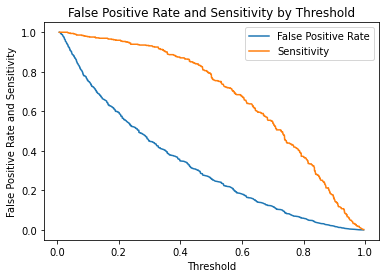

In [37]:
fig, ax = plt.subplots()
ax.plot(ths, fpr, label="False Positive Rate")
ax.plot(ths, tpr, label="Sensitivity")
ax.set(
    title="False Positive Rate and Sensitivity by Threshold",
    xlabel="Threshold",
    ylabel="False Positive Rate and Sensitivity",
)
ax.legend()

^ Here we can  see that as we lower the threshold to below 0.25, the false positive rate increases more rapidly than sensitivity.

### Threshold with Youden J

We will calculate the **Youden J** statistic to find the threhsold value. We get this by passing a vector, which is the difference between the true positive and false positive rates at each threshold, to the NumPy's `argmax` function. We want the value of the threshold at that index.

In [38]:
jthresh = ths[np.argmax(tpr - fpr)]
jthresh

0.46728451504546487

^ The optimal threshold according to this calculation is 0.46, which isn't very different from the default.

We can redo the confusion matrix based on this alternative threshold.

[Text(0.5, 1.0, 'Heart Disease Prediction Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

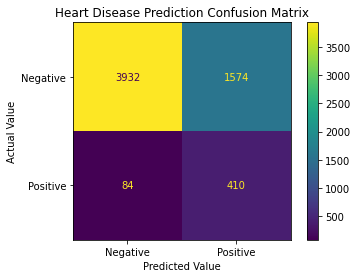

In [39]:
y_pred2 = np.where(pred_probs >= jthresh, 1, 0)
cm = skmet.confusion_matrix(y_test, y_pred2)
cmplot = skmet.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Negative", "Positive"]
)
cmplot.plot()

cmplot.ax_.set(
    title="Heart Disease Prediction Confusion Matrix",
    xlabel="Predicted Value",
    ylabel="Actual Value",
)

In [40]:
print(skmet.recall_score(y_test, y_pred))
print(skmet.recall_score(y_test, y_pred2))

0.7874493927125507
0.8299595141700404


^ This gives us a small increase improvement in sensitivity.

## Regularization with logistic regression

How regularization works - we add penalty to our estimator that minimizes our parameter estimates. 

### Import dependencies

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import uniform
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from data.load import load_healthinfosample
from preprocfunc import MakeOrdinal, OutlierTrans, ReplaceVals

### Load data

In [42]:
healthinfo = load_healthinfosample()
healthinfo["heartdisease"] = np.where(healthinfo.heartdisease == "No", 0, 1).astype(
    "int"
)

### Preprocessing

In [43]:
num_cols = ["bmi", "physicalhealthbaddays", "mentalhealthbaddays", "sleeptimenightly"]
binary_cols = [
    "smoking",
    "alcoholdrinkingheavy",
    "stroke",
    "walkingdifficult",
    "physicalactivity",
    "asthma",
    "kidneydisease",
    "skincancer",
]

cat_cols = ["gender", "ethnicity"]
spec_cols1 = ["agecategory"]
spec_cols2 = ["genhealth"]
spec_cols3 = ["diabetic"]

In [44]:
rep_dict = {
    "genhealth": {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4},
    "diabetic": {
        "No": 0,
        "No, borderline diabetes": 0,
        "Yes": 1,
        "Yes (during pregnancy)": 1,
    },
}

### Create train and test data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    healthinfo[
        num_cols + binary_cols + cat_cols + spec_cols1 + spec_cols2 + spec_cols3
    ],
    healthinfo["heartdisease"],
    test_size=0.2,
    random_state=0,
)

### Column Transformation

In [46]:
ohe = OneHotEncoder(drop="first", sparse=False)

standtrans = make_pipeline(
    OutlierTrans(3), SimpleImputer(strategy="median"), StandardScaler()
)
spectrans1 = make_pipeline(MakeOrdinal(), StandardScaler())
spectrans2 = make_pipeline(ReplaceVals(rep_dict), StandardScaler())
spectrans3 = make_pipeline(ReplaceVals(rep_dict))
bintrans = make_pipeline(ohe)
cattrans = make_pipeline(ohe)
coltrans = ColumnTransformer(
    transformers=[
        ("stand", standtrans, num_cols),
        ("spec1", spectrans1, spec_cols1),
        ("spec2", spectrans2, spec_cols2),
        ("spec3", spectrans3, spec_cols3),
        ("bin", bintrans, binary_cols),
        ("cat", cattrans, cat_cols),
    ]
)

### Setup pipeline

In [54]:
lr = LogisticRegression(random_state=1, class_weight="balanced", max_iter=1000)
kf = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=3)

pipe1 = make_pipeline(coltrans, lr)
reg_params = [
    {
        "logisticregression__solver": ["liblinear"],
        "logisticregression__penalty": ["l1", "l2"],
        "logisticregression__C": uniform(loc=0, scale=10),
    },
    {
        "logisticregression__solver": ["newton-cg"],
        "logisticregression__penalty": ["l2"],
        "logisticregression__C": uniform(loc=0, scale=10),
    },
    {
        "logisticregression__solver": ["saga"],
        "logisticregression__penalty": ["elasticnet"],
        "logisticregression__l1_ratio": uniform(loc=0, scale=1),
        "logisticregression__C": uniform(loc=0, scale=10),
    },
]

rs = RandomizedSearchCV(pipe1, reg_params, cv=kf, n_iter=20, scoring="roc_auc")
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=7, random_state=3),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('stand',
                                                                               Pipeline(steps=[('outliertrans',
                                                                                                OutlierTrans(threshold=3)),
                                                                                               ('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['bmi',
                                                                                'physicalhealthbaddays...
                                         'logisticregression__penalty': ['l2'],
                                         'logisticregression__solver': ['newton-cg']},
                                        {'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x120852640>,
                                         'logisticregression__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12080ed30>,
                                         'logisticregression__penalty': ['elasticnet'],
                                         'logisticregression__solver': ['saga']}],
                   scoring='roc_auc')

In [55]:
rs.best_params_

{'logisticregression__C': 2.557336956229652,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [56]:
rs.best_score_

0.8412452956473805

In [57]:
results = (
    pd.DataFrame(rs.cv_results_["mean_test_score"], columns=["meanscore"])
    .join(pd.json_normalize(rs.cv_results_["params"]))
    .sort_values(["meanscore"], ascending=False)
)

^ The `cv_results_` dictionary of the grid search provides us with lots of information about the 20 models that were tried. The `params` list in that dictionary has a somewhat complicated structure because some keys are not present for some iterations, such as `L1_ratio`. We use `json_normalize` to flatten the structure.

[Text(0.5, 1.0, 'Heart Disease Prediction Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

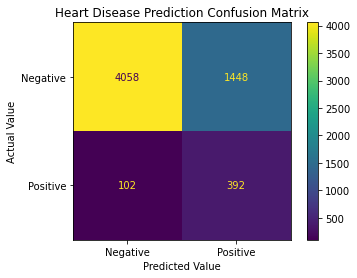

In [58]:
y_pred = rs.predict(X_test)

cm = skmet.confusion_matrix(y_test, y_pred)
cmplot = skmet.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Negative", "Positive"]
)
cmplot.plot()
cmplot.ax_.set(
    title="Heart Disease Prediction Confusion Matrix",
    xlabel="Predicted Value",
    ylabel="Actual Value",
)

### Metrics: Classification report

In [62]:
print(skmet.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      5506
           1       0.21      0.79      0.34       494

    accuracy                           0.74      6000
   macro avg       0.59      0.77      0.59      6000
weighted avg       0.91      0.74      0.80      6000



^ Our scores are largely unchanged from our model without regularization.

## Multinomial logistic regression


Logistic regression would not be as useful if it only worked for binary classification problems. Fortunately, we can use multinomial logistic regression when our target has more than two values.

In this section, we want to predict if a machine failed or didn't, and the type of failure.

In [84]:
# Force load without restarting kernel.
import importlib

import data.load as load

importlib.reload(load)

from data.load import load_machinefailuretype

### Import dependencies

In [116]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Load data

In [117]:
machinefailuretype = load_machinefailuretype()
machinefailuretype.head()

,udi,product,machinetype,airtemp,processtemperature,rotationalspeed,torque,toolwear,fail,failtype
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [118]:
machinefailuretype.describe().T

,count,mean,std,min,25%,50%,75%,max
udi,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
airtemp,10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
processtemperature,10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
rotationalspeed,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
torque,10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
toolwear,10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
fail,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0


In [119]:
machinefailuretype.describe(include=["O"]).T

,count,unique,top,freq
product,10000,10000,L48332,1
machinetype,10000,3,L,6000
failtype,10000,6,No Failure,9652


In [120]:
machinefailuretype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   udi                 10000 non-null  int64  
 1   product             10000 non-null  object 
 2   machinetype         10000 non-null  object 
 3   airtemp             10000 non-null  float64
 4   processtemperature  10000 non-null  float64
 5   rotationalspeed     10000 non-null  int64  
 6   torque              10000 non-null  float64
 7   toolwear            10000 non-null  int64  
 8   fail                10000 non-null  int64  
 9   failtype            10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [121]:
machinefailuretype.shape

(10000, 10)

In [122]:
machinefailuretype.failtype.value_counts(dropna=False)

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: failtype, dtype: int64

In [123]:
machinefailuretype.machinetype.value_counts(dropna=False).sort_index()

H    1003
L    6000
M    2997
Name: machinetype, dtype: int64

In [124]:
code_by_typetext = {
    "No Failure": 1,
    "Heat Dissipation Failure": 2,
    "Power Failure": 3,
    "Overstrain Failure": 4,
    # We combine the last two because their frequency is too low.
}


def setcode(typetext):
    return code_by_typetext.get(typetext, 5)


machinefailuretype["failtypecode"] = machinefailuretype.apply(
    lambda row: setcode(row.failtype), axis=1
)

In [125]:
machinefailuretype.groupby(["failtype", "failtypecode"]).size().reset_index()

,failtype,failtypecode,0
0,Heat Dissipation Failure,2,112
1,No Failure,1,9652
2,Overstrain Failure,4,78
3,Power Failure,3,95
4,Random Failures,5,18
5,Tool Wear Failure,5,45


### Create train and test data

In [126]:
num_cols = ["airtemp", "processtemperature", "rotationalspeed", "torque", "toolwear"]
cat_cols = ["machinetype"]

machinefailuretype[num_cols].agg(["min", "median", "max"]).T

,min,median,max
airtemp,295.3,300.1,304.5
processtemperature,305.7,310.1,313.8
rotationalspeed,1168.0,1503.0,2886.0
torque,3.8,40.1,76.6
toolwear,0.0,108.0,253.0


In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    machinefailuretype[num_cols + cat_cols],
    machinefailuretype["failtypecode"],
    test_size=0.2,
    random_state=0,
)

In [128]:
ohe = OneHotEncoder(drop="first", sparse=False)
standtrans = make_pipeline(
    OutlierTrans(3), SimpleImputer(strategy="median"), StandardScaler()
)
cattrans = make_pipeline(ohe)
coltrans = ColumnTransformer(
    transformers=[("stand", standtrans, num_cols), ("cat", cattrans, cat_cols)]
)

In [129]:
lr = LogisticRegression(
    random_state=0, multi_class="multinomial", solver="lbfgs", max_iter=1000
)
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
pipe1 = make_pipeline(coltrans, lr)

[Text(0.5, 1.0, 'Machine Failure Type Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

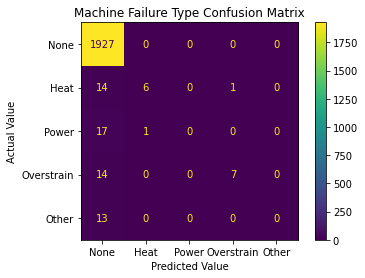

In [130]:
pipe1.fit(X_train, y_train)
y_pred = pipe1.predict(X_test)

cm = skmet.confusion_matrix(y_test, y_pred)
cmplot = skmet.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["None", "Heat", "Power", "Overstrain", "Other"]
)
cmplot.plot()
cmplot.ax_.set(
    title="Machine Failure Type Confusion Matrix",
    xlabel="Predicted Value",
    ylabel="Actual Value",
)

^ The confusion matrix shows that our model does not do a good job of predicting the failure type when there is a failure, particularly with power failure or other failures.

In [131]:
scores = cross_validate(
    pipe1,
    X_train,
    y_train,
    scoring=[
        "accuracy",
        "precision_weighted",
        "recall_weighted",
        "f1_macro",
        "f1_weighted",
    ],
    cv=kf,
    n_jobs=-1,
)

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Pr

In [133]:
accuracy = np.mean(scores["test_accuracy"])
precision = np.mean(scores["test_precision_weighted"])
sensitivity = np.mean(scores["test_recall_weighted"])
f1_macro = np.mean(scores["test_f1_macro"])
f1_weighted = np.mean(scores["test_f1_weighted"])

accuracy, precision, sensitivity, f1_macro, f1_weighted

(0.9716499999999999,
 0.9541025493784612,
 0.9716499999999999,
 0.3820938909478524,
 0.9611411229222823)

## Summary

- use logistic regression to predict categorical target
- it is an efficient algorithm with low bias
- some of the disadvantages such as high variance and difficulty handling correlated predictors can be addressed with regularization and feature selection


An alternative to logistic regression for classification is decision trees. 